# このノートでやった（できる）こと
### Logistic regressionを用いて、目的変数の確率を算出し、算出した値を元に様々な掛け方をした場合の回収率を計算

#### 計算に用いた特徴量
- 各レーサーのクラス
- 各レーサーの各枠における平均スタートタイム
- 各レーサーの連帯率
- 展示タイム
- 各モーターの2連率
- 各モーターの3連率
- 各ボートの2連率
- 各ボートの3連率

#### 目的変数
- 1枠: 1着になる (1) or ならない (0)
- 2-6枠: 3着以内にはいる (1) or 入らない (0)


### 結果
#### RandomForest classification結果
- XXX
- XXX
#### bet結果


In [47]:
# 必要なモジュールのインポート

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
# import termcolor
from datetime import datetime

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '../conf/'))
sys.path.append(os.path.join(current_dir, '../crawl/'))
sys.path.append(os.path.join(current_dir, '../data_preparing/'))
sys.path.append(os.path.join(current_dir, 'analyzer_conf/'))

# my module
import loader
import boatrace_crawler_conf
import analyzer_conf

In [48]:
# 過去のレース結果をdfとして取得
the_merged_df = loader.main()
# dfをソート
the_merged_df = the_merged_df.sort_values(["date", "venue", "raceNumber"])
# print(the_merged_df["CS_frame_1_1"])

C:\Users\02217013\Documents\GitHub\boatrace\src\analyze\../data_preparing\loader.py:357: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  race_results_supplementary_df = pd.concat(race_results_supplementary_df_list)


In [44]:
# dfを期間で区切って小さくして使いたい時
from_dt = datetime(2019, 1, 1)
to_dt = datetime(2019, 3, 1)

the_merged_df = the_merged_df[(the_merged_df["date"] >= from_dt) & (the_merged_df["date"] <= to_dt)]

In [49]:
# Random forest regressionを利用した学習

def make_df_for_analyze(merged_df, fv_list, column_list_label, odds_list):
    """
    parameters
        fv_list: dfのうち、特徴量として用いるカラム名のリスト
        column_list_label: dfのうち、labelとして用いるカラム名のリスト
    """
    
    # 特徴量のdfを作成
    fv_df = merged_df[fv_list]
    
    # クラスカラムを，A1 =0, A2 = 1のように数字に変換する
    class_dict = {"A1": 0, "A2":1, "B1": 2, "B2": 3}
    for key, value in class_dict.items():
        fv_df.replace(key, value, inplace = True)

    # 会場名をbooleanに変換
    venue_df = pd.get_dummies(fv_df["venue"])
    
    # fv_dfの方の会場の列を削除
    fv_df = fv_df.drop("venue", axis=1)
    
    # 会場名がbooleanになったfv_dfの作成
    fv_df = pd.concat([fv_df, venue_df], axis=1)
    
    # なぜかdtypeがstrになっちゃうのでfloatに戻す
    fv_df = fv_df.astype(float)
    
    # labelのdfを作成
    label_df = merged_df[column_list_label]
    
    # ラベルをbooleanに変換
    label_df = analyzer_conf.make_label_boolean_ver1(label_df, column_list_label)
    
    """
    # 特徴量を標準化
    fv_label_df = analyzer_conf.standerdize_feature_values(
        fv_label_df, column_list_label)
    """
    
    # オッズのdfを作成
    odds_df = merged_df[odds_list]
    
    # 解析用dfを作成
    fv_label_odds_df = pd.concat([fv_df, label_df, odds_df], axis=1)
    # nanを含む行を削除
    fv_label_odds_df = fv_label_odds_df.dropna()
    
    # oddsはないバージョンのdf
    fv_label_df = pd.concat([fv_df, label_df], axis=1)
    # nanを含む行を削除
    fv_label_df = fv_label_df.dropna()
    
    """
    print(len(fv_df), len(label_df), len(odds_df))
    print("解析用dfの行数は.{0}".format(len(fv_label_df)))
    print(fv_label_df)
    """
    
    return fv_label_df, fv_label_odds_df


def separate_train_test_dataset(for_analysis_df, train_data_ratio):
       
    # 解析用df（特徴量+label）を、学習用データとテストデータのarrayに分ける
    train_size = int(len(for_analysis_df) * train_data_ratio)
    train_data = for_analysis_df[:train_size].values
    test_data = for_analysis_df[train_size:].values
    
    return train_data, test_data, train_size

    
def learn_logistic_regression(train_data, column_list_label, num_estimators, max_depth, max_features):
    
    """
    1枠が1着になるかどうか？2枠以降に関しては3着以内に入るかどうか？を scikit-lernのlogistic regressionを用いて学習する。
    複数のラベルをリストとして入力することが可能で、戻り値はそれぞれのlabelに対して学習を行なった結果のモデルを各要素にもつリスト
    
    return
        clf_list: 各ラベルについて学習したモデルのlist
    
    TODO
        ラベルの作成方法などもinput parameterとして指定できた方がいい。
        むしろregressionの方法もinputにして超汎用的な関数を外側に作るか？
    
    """
    # ラベルとしてもちいる部分の数。labelと特徴量を分ける際に使用、
    num_labels = len(column_list_label)
    
    # 特徴量部分のarray
    train_x = train_data[:, :-num_labels]

    # 分類を行なった結果得られるオブジェクトをリストに格納
    clf_list  = []

    for i, column_label in enumerate(column_list_label):
        # ラベルを指定
        train_t = train_data[:, - num_labels + i]

        # Random Forest Classification
        clf = RFC(n_estimators=num_estimators, max_depth=max_depth, max_features=max_features, n_jobs=-1)
        clf.fit(train_x, train_t)

        clf_list.append(clf)
    
    return clf_list, num_labels


# ----------input-------------
# 解析に使う特徴量カラム
fv_list = []

# 開催地
fv_list.append("venue")    

for i in range(1, 7):
    # 各枠のレーサーのクラス
    fv_list.append("class_{0}".format(i))
    # 各レーサーの該当枠における平均ST
    fv_list.append("aveST_frame{0}".format(i))
    # 各レーサーの該当枠における連帯率
    fv_list.append("placeRate_frame{0}".format(i))
    
    # 勝率・二連率・三連率（全国）
    fv_list.append("win_rate_national_{0}".format(i))
    fv_list.append("place2Ratio_national_{0}".format(i))
    fv_list.append("place3Ratio_national_{0}".format(i))
    
    # 勝率・二連率・三連率（当地）
    fv_list.append("win_rate_local_{0}".format(i))
    fv_list.append("place2Ratio_local_{0}".format(i))
    fv_list.append("place3Ratio_local_{0}".format(i))
    
    # 展示タイム
    fv_list.append("exhibitionTime_{0}".format(i))
    
    # 各モーターの2連率, 3連率
    fv_list.append("motor_place2Ratio_{0}".format(i))
    fv_list.append("motor_place3Ratio_{0}".format(i))
    
    # ボートの2連率、3連率
    fv_list.append("boat_place2Ratio_{0}".format(i))
    fv_list.append("boat_place3Ratio_{0}".format(i))
    
    # 展示競争の進入コース
    fv_list.append("exhibition_cource_{0}".format(i))
    
    
    # 直前のレースの成績
    # for j in range(1, 12):
        # fv_list.append("CS_frame_{0}_{1}".format(i, j))
        # fv_list.append("CS_rank_{0}_{1}".format(i, j))

# 解析に使うラベルカラム: 1枠が1着になるか, 2枠以降は3着以降に入るかどうか？を予測
column_list_label = ["rank_{0}".format(i) for i in range(1,7)]

# 回収率計算に使用するオッズラベルのリスト
odds_list =  ["win", "winOdds", 
             "place_1", "placeOdds_1",
             "place_2", "placeOdds_2",
             "exacta", "exactaOdds",
             "quinella", "quinellaOdds",
             "wide_1", "wideOdds_1", 
             "wide_2", "wideOdds_2",
             "wide_3", "wideOdds_3",
             "trifecta", "trifectaOdds",
             "trio", "trioOdds"]

# データのうち、教師データとして使う割合（残りをテストデータとして用いる）
train_data_ratio = 0.8
# random forestの木の本数
num_estimators = 100
# 探索木の最大深さ
max_depth = 8
#  サンプリングする特徴量の数
max_features = None

# --------------------------------

# main

fv_label_df, fv_label_odds_df = make_df_for_analyze(the_merged_df, fv_list, column_list_label, odds_list)
train_data, test_data, train_size = separate_train_test_dataset(fv_label_df, train_data_ratio)
clf_list, num_labels = learn_logistic_regression(train_data, column_list_label, num_estimators, max_depth, max_features)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\02217013\Documents\GitHub\boatrace\src\analyze\analyzer_conf.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for_analysis_df.loc[for_analysis_df[column_name] != 1, column_name] = 0
C:\

In [5]:
print(fv_label_df)

       class_1  aveST_frame1  placeRate_frame1  win_rate_national_1  \
96         0.0          18.0             853.0                 7.14   
97         2.0          16.0             545.0                 5.51   
98         1.0          13.0             880.0                 6.29   
99         2.0          18.0             273.0                 3.58   
100        0.0          15.0             923.0                 6.50   
101        2.0          14.0             417.0                 4.46   
102        1.0          15.0             682.0                 6.30   
103        0.0          16.0             840.0                 5.91   
104        0.0          13.0             885.0                 7.13   
105        0.0          14.0             848.0                 7.80   
36         0.0          15.0             739.0                 6.86   
37         2.0          19.0             538.0                 5.05   
38         2.0          35.0             250.0                 3.24   
39    

In [6]:
print(fv_label_odds_df)

       class_1  aveST_frame1  placeRate_frame1  win_rate_national_1  \
96         0.0          18.0             853.0                 7.14   
97         2.0          16.0             545.0                 5.51   
98         1.0          13.0             880.0                 6.29   
99         2.0          18.0             273.0                 3.58   
100        0.0          15.0             923.0                 6.50   
101        2.0          14.0             417.0                 4.46   
102        1.0          15.0             682.0                 6.30   
103        0.0          16.0             840.0                 5.91   
104        0.0          13.0             885.0                 7.13   
105        0.0          14.0             848.0                 7.80   
36         0.0          15.0             739.0                 6.86   
37         2.0          19.0             538.0                 5.05   
38         2.0          35.0             250.0                 3.24   
39    

1号艇についてtrainデータを使った正解率は0.7600107933081489,
           testデータを使った正解率は0.6354413986617742
	venue                : 0.063049
	aveST_frame1         : 0.381143
2号艇についてtrainデータを使った正解率は0.7598488936859147,
           testデータを使った正解率は0.6205482408806389
	placeRate_frame1     : 0.017527
	exhibition_cource_1  : 0.021122
	aveST_frame2         : 0.250877
	placeRate_frame2     : 0.017868
	place3Ratio_national_2 : 0.015919
	aveST_frame3         : 0.018050
	placeRate_frame3     : 0.015856
	win_rate_national_3  : 0.016546
	aveST_frame4         : 0.018759
	placeRate_frame4     : 0.015940
	aveST_frame5         : 0.016798
3号艇についてtrainデータを使った正解率は0.7665407447382623,
           testデータを使った正解率は0.6164472264191668
	aveST_frame2         : 0.017006
	placeRate_frame2     : 0.018174
	exhibition_cource_2  : 0.072917
	aveST_frame3         : 0.179304
	placeRate_frame3     : 0.033967
	place2Ratio_national_3 : 0.022926
	exhibitionTime_3     : 0.018311
	aveST_frame4         : 0.019027
	placeRate_frame4     : 0.022117
	place

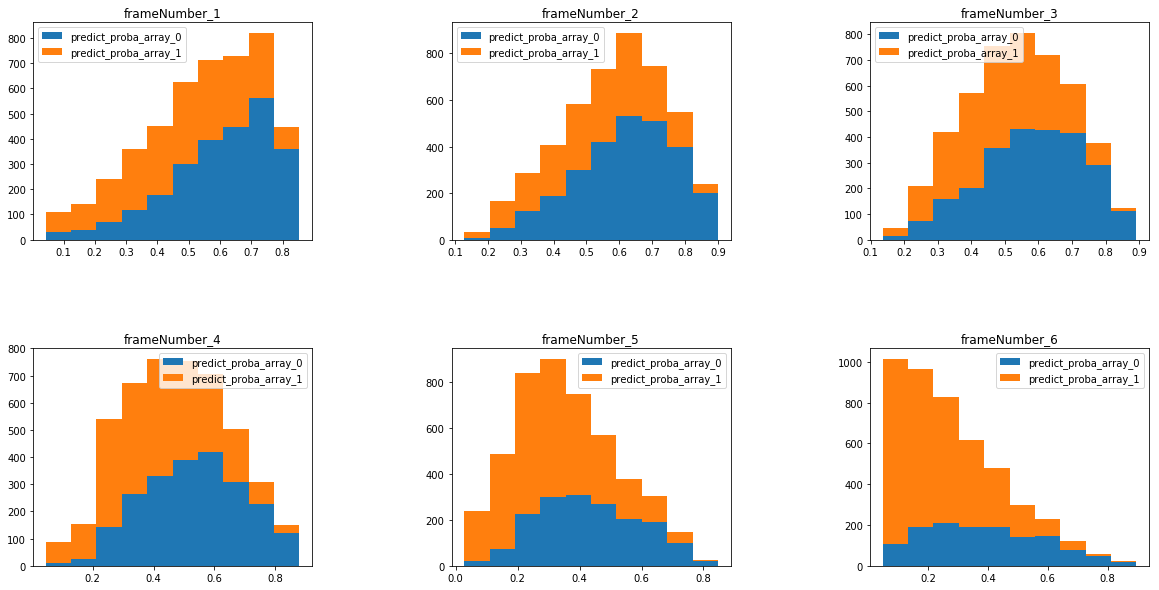

In [50]:
"""
上のセルで学習したclfを用いて色々と解析する。
今このセルで行なっている解析は
1. 各labelについて正解率を計算
2. 最適化された結果の切片および各係数を表示
3. テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成

"""
# 描画用の枠を用意

plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

# 回収率計算用に、[predict_proba_array, test_t]を各要素にもつリストを作成
predict_proba_array_list = []

# 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
train_x = train_data[:, :-num_labels]
test_x = test_data[:, :-num_labels]

for i, clf in enumerate(clf_list):
    train_t = train_data[:, - num_labels + i]
    test_t = test_data[:, - num_labels + i]
    
    # 正解率を計算
    train_score = clf.score(train_x, train_t)
    test_score = clf.score(test_x, test_t)
    print("{2}号艇についてtrainデータを使った正解率は{0},\n \
          testデータを使った正解率は{1}".format(train_score, test_score, i + 1))
    
    # Feature Importance
    fti = clf.feature_importances_
    for j, fv in enumerate(fv_list):
        if fti[j] > 0.015:
            print('\t{0:20s} : {1:>.6f}'.format(fv, fti[j]))

    # テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成
    predict_proba_array = clf.predict_proba(test_x)
    
    # listに格納しておく
    predict_proba_array_list.append(predict_proba_array[:, 1])

    # 結果が1 (1枠が一着 , 2枠以降が3着以内) だったものの推定確率
    predict_proba_array_1 = predict_proba_array[:, 1][test_t==1]

    # 結果が0 (1枠以外が一着, 1枠以外の場合は4着以降) だったものの推定確率
    predict_proba_array_0 = predict_proba_array[:, 1][test_t==0]

    # 積み上げヒストグラムを作成
    title = "frameNumber_{0}".format(i + 1)
    labels = {'predict_proba_array_1', 'predict_proba_array_0'}
    plt.subplot(2, 3, i+1)
    plt.hist([predict_proba_array_1, predict_proba_array_0], histtype="barstacked", label=labels)
    plt.title(title)
    plt.legend()
plt.show()

### Random Forest 最適なパラメータさがし
- n_estimator...500くらいで十分
- max_depth
- 

KeyboardInterrupt: 

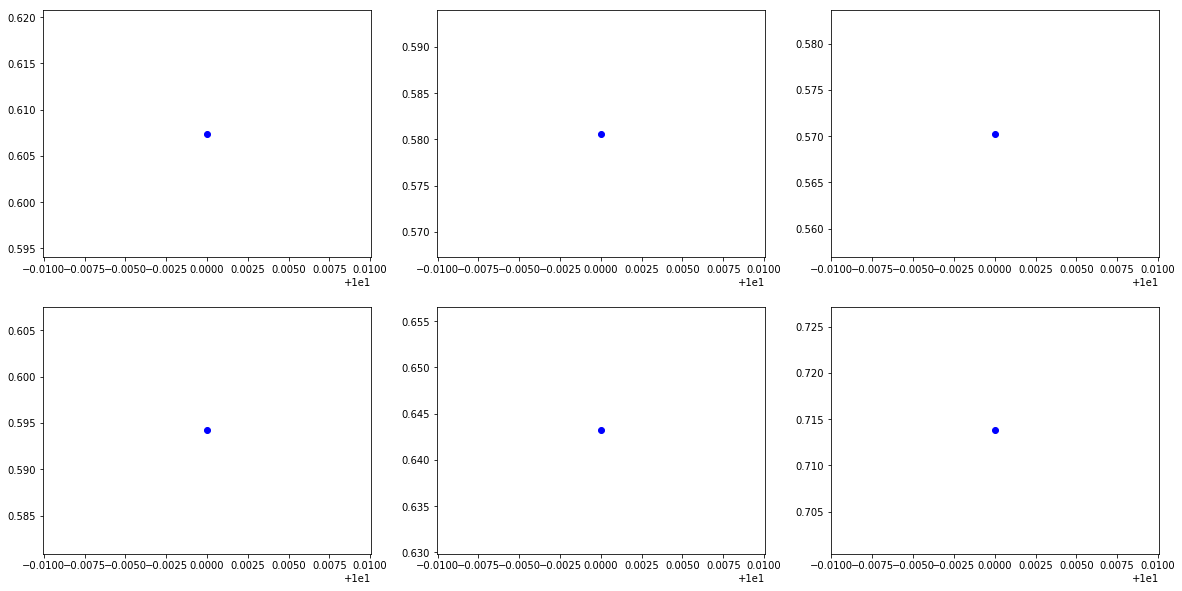

In [55]:
num_estimators_list = [10, 50, 100, 200, 500, 1000]
max_depth = None
max_features = None

# 1つ目の要素に一号艇について、２つ目のリストは二号ていについての結果を、各num_estimatorsの値について格納していく

plt.figure(figsize=(20, 10))

for num_estimators in num_estimators_list:
    clf_list, num_labels = learn_logistic_regression(train_data, column_list_label, num_estimators, max_depth, max_features)
    # 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
    train_x = train_data[:, :-num_labels]
    test_x = test_data[:, :-num_labels]

    for i, clf in enumerate(clf_list):
        train_t = train_data[:, - num_labels + i]
        test_t = test_data[:, - num_labels + i]

        # 正解率を計算
        train_score = clf.score(train_x, train_t)
        test_score = clf.score(test_x, test_t)
        
        plt.subplot(2, 3, i+1)
        # plt.scatter(num_estimators, train_score, c="red")
        plt.scatter(num_estimators, test_score, c="blue")

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: Matplotlib

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: Matplotlib

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: Matplotlib

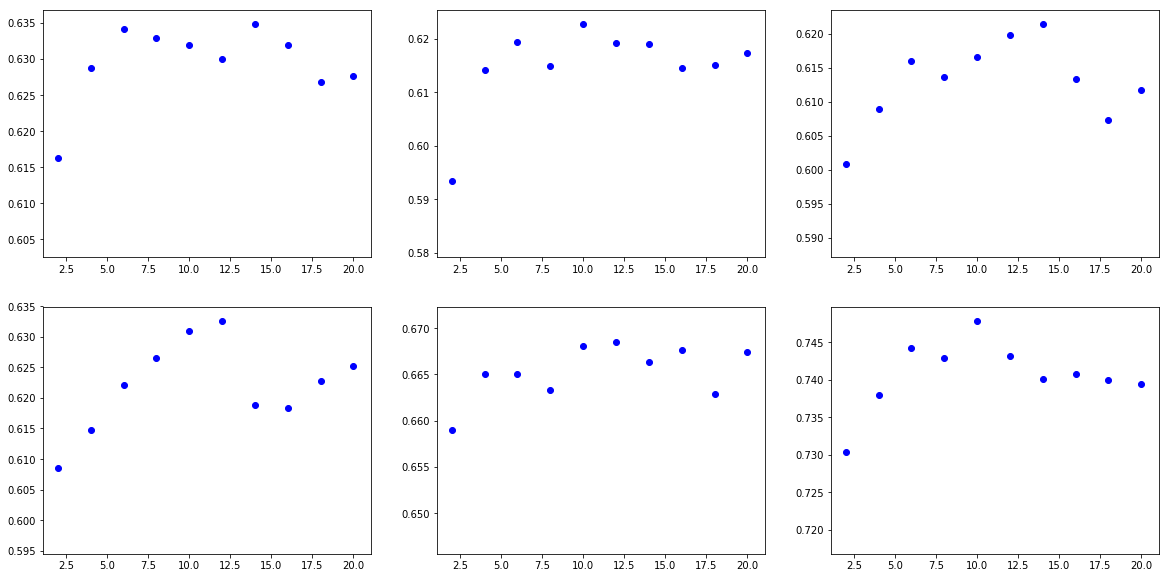

In [58]:
num_estimators = 100
max_depth_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
max_features = None

# 1つ目の要素に一号艇について、２つ目のリストは二号ていについての結果を、各num_estimatorsの値について格納していく

plt.figure(figsize=(20, 10))

for max_depth in max_depth_list:
    clf_list, num_labels = learn_logistic_regression(train_data, column_list_label, num_estimators, max_depth, max_features)
    # 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
    train_x = train_data[:, :-num_labels]
    test_x = test_data[:, :-num_labels]

    for i, clf in enumerate(clf_list):
        train_t = train_data[:, - num_labels + i]
        test_t = test_data[:, - num_labels + i]

        # 正解率を計算
        train_score = clf.score(train_x, train_t)
        test_score = clf.score(test_x, test_t)
        
        plt.subplot(2, 3, i+1)
        # plt.scatter(max_depth, train_score, c="red")
        plt.scatter(max_depth, test_score, c="blue")

plt.show()

In [59]:
num_estimators = 100
max_depth = None
max_features_list = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]

# 1つ目の要素に一号艇について、２つ目のリストは二号ていについての結果を、各num_estimatorsの値について格納していく

plt.figure(figsize=(20, 10))

for max_featuresuremax_featuresax_features_list:
    clf_list, num_labels = learn_logistic_regression(train_data, column_list_label, num_estimators, max_depth, max_features)
    # 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
    train_x = train_data[:, :-num_labels]
    test_x = test_data[:, :-num_labels]

    for i, clf in enumerate(clf_list):
        train_t = train_data[:, - num_labels + i]
        test_t = test_data[:, - num_labels + i]

        # 正解率を計算
        train_score = clf.score(train_x, train_t)
        test_score = clf.score(test_x, test_t)
        
        plt.subplot(2, 3, i+1)
        # plt.scatter(max_depth, train_score, c="red")
        plmax_featuresturesuresturesturesres(max_features, test_score, c="blue")

plt.show()

SyntaxError: invalid syntax (<ipython-input-59-fbe831f4ff6b>, line 9)

# 考察
- 正解率はいずれのラベルに対しても6割から7割程度にとどまるが、test dataとtraining dataで同程度の正解率をだす。
確率ごとにプロットをしてみると、
- predict_probaが小さい時は実際に0ラベル、predict_probaが大きい時は実際に1ラベルであることがかなり多くなっている。
- 正解率を下げているのは実際に判断が難しいところ（0.3 < predict_proba < 0.7くらいの場所） であり、predict_probaが高いところ、低いところを抽出して用いることで十分に予測器として使用可能
- 1着以外が1位になる，荒れるレースの予測や、1着を1枠に固定し、2, 3を高いprobabilityを示すものでbox買するといったオプションが考えられる。

そこで、以下のセルにおいては掛け方を色々してみた時の回収率計算を行う。

In [52]:
# 計算用dfを作成
# 6列目までが上の解析によって求めた確率(1号艇が1位になる率, 2-6号艇が3位以内に入る確率)
# 7列目以降にオッズ関係の値を格納

for_calc_refund_rate_df = pd.DataFrame(np.vstack(predict_proba_array_list).T, columns=["PredProb_{0}".format(i) for i in range(1, 7)])
for odds_column_name in odds_list:
    # TODO intで入れられるものはintで。無理なものはとりあえずobjectのままで格納
    for_calc_refund_rate_df[odds_column_name] = fv_label_odds_df[odds_column_name][train_size:].values

print(for_calc_refund_rate_df)

      PredProb_1  PredProb_2  PredProb_3  PredProb_4  PredProb_5  PredProb_6  \
0       0.817770    0.598635    0.438678    0.291206    0.443241    0.341548   
1       0.499031    0.502284    0.517262    0.699576    0.186778    0.168857   
2       0.231455    0.757978    0.820562    0.269349    0.337257    0.338260   
3       0.338126    0.620455    0.500852    0.738027    0.466430    0.056964   
4       0.251845    0.778745    0.693487    0.136490    0.662731    0.450072   
5       0.437841    0.237006    0.750571    0.401157    0.623871    0.442956   
6       0.336111    0.838110    0.571616    0.234415    0.716691    0.118667   
7       0.405049    0.828341    0.721230    0.549706    0.160172    0.387712   
8       0.609345    0.756088    0.185841    0.356306    0.516707    0.695229   
9       0.840584    0.609940    0.636547    0.562113    0.055586    0.522335   
10      0.693462    0.508160    0.380090    0.226165    0.475818    0.749844   
11      0.648820    0.486163    0.649333

In [54]:
# 確率x_1以上のときのみ、1に単勝賭けした時の回収率
x_1_list = [0.6, 0.7, 0.8, 0.9]
for x_1 in x_1_list:
    bet = sum(for_calc_refund_rate_df["PredProb_1"] > x_1)

    return_boolean = (for_calc_refund_rate_df["PredProb_1"] > x_1) & (for_calc_refund_rate_df["win"] == "1")
    return_ = sum(for_calc_refund_rate_df["winOdds"][return_boolean])

    print("確率{0}以上で1に単勝betした場合、的中率は{1}, 回収率は{2}".format(x_1, sum(return_boolean) / bet, return_ / (bet * 100)))

確率0.6以上で1に単勝betした場合、的中率は0.6799233349305223, 回収率は0.9208433157642549
確率0.7以上で1に単勝betした場合、的中率は0.7285714285714285, 回収率は0.9169747899159664
確率0.8以上で1に単勝betした場合、的中率は0.832579185520362, 回収率は0.9307692307692308


ZeroDivisionError: division by zero

In [42]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率がx_2超えがあった場合に、1-XY..の形で2連単bet

x_1_list = [0.7, 0.75, 0.8]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "1-{0}".format(j)
                        bet = bet + 100
                        if row["exacta"] == bet_num:
                            income = income + row["exactaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で2連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.7以上かつ、p2-6が0.5以上で2連単betすると収益は-5110, 回収率は0.9643156424581005
p1が0.7以上かつ、p2-6が0.6以上で2連単betすると収益は-1820, 回収率は0.9775862068965517
p1が0.7以上かつ、p2-6が0.7以上で2連単betすると収益は-2000, 回収率は0.9493670886075949
p1が0.7以上かつ、p2-6が0.8以上で2連単betすると収益は-410, 回収率は0.9605769230769231
p1が0.75以上かつ、p2-6が0.5以上で2連単betすると収益は-1310, 回収率は0.9863966770508826
p1が0.75以上かつ、p2-6が0.6以上で2連単betすると収益は-1510, 回収率は0.9719330855018588
p1が0.75以上かつ、p2-6が0.7以上で2連単betすると収益は-3320, 回収率は0.8727969348659004
p1が0.75以上かつ、p2-6が0.8以上で2連単betすると収益は-640, 回収率は0.9058823529411765
p1が0.8以上かつ、p2-6が0.5以上で2連単betすると収益は-1140, 回収率は0.9786915887850467
p1が0.8以上かつ、p2-6が0.6以上で2連単betすると収益は-2120, 回収率は0.9288590604026845
p1が0.8以上かつ、p2-6が0.7以上で2連単betすると収益は-1780, 回収率は0.8851612903225806
p1が0.8以上かつ、p2-6が0.8以上で2連単betすると収益は130, 回収率は1.0282608695652173


In [33]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9と1-9-Xの形で3連単bet
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 200
                                bet_num_1 = "1-{0}-{1}".format(j, k)
                                bet_num_2 = "1-{0}-{1}".format(k, j)
                                # print(bet_num_1, bet_num_2, row["trifecta"], row["trifectaOdds"])
                                if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-319020, 回収率は0.8164019337016575
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-118740, 回収率は0.8426033934252386
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-14100, 回収率は0.9392241379310344
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-129240, 回収率は0.8545904590459046
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-43630, 回収率は0.8941019417475728
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-12520, 回収率は0.9045731707317073
p1が0.8以上かつ、p2-6が0.6以上で3連単betすると収益は-33360, 回収率は0.9034722222222222
p1が0.8以上かつ、p2-6が0.7以上で3連単betすると収益は-12060, 回収率は0.9257389162561577
p1が0.8以上かつ、p2-6が0.8以上で3連単betすると収益は4620, 回収率は1.0916666666666666


In [ ]:
# 上と同じノリで2着固定。すなわち、
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9の形で3連単bet
x_1_list = [0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

In [ ]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以下が2艇以上あった場合に、1頭で、2割以下艇を外した残りを2, 3着boxにして買う
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.4, 0.3, 0.2]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                outers = (row[["PredProb_{0}".format(n) for n in range(2, 7)]] < x_2)
                num_outers = sum(outers)
                if (num_outers > 1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                    bet = bet + 100
                                    bet_num = "1-{0}-{1}".format(j, k)
                                    if row["trifecta"] == bet_num:
                                        income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

In [34]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が2艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
x_1_list = [0.5, 0.6, 0.7, 0.75, 0.8]
x_2_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("投票候補なし")

NameError: name 'termcolor' is not defined

In [53]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が1艇, X_3以上が1艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
# ただし、2-6号艇のうち二つ以上の艇がx_２を超えていた場合、それらに対しては2倍のbet額になるアルゴリズムになっている
x_1_list = [0.6, 0.7, 0.75, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-217180, 回収率は0.8101573426573426
p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-180300, 回収率は0.77286470143613
p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は-90760, 回収率は0.810601001669449
p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は-45200, 回収率は0.8144499178981938
p1が0.6以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-38090, 回収率は0.9003401360544218
p1が0.6以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は-47910, 回収率は0.8132891660171473
p1が0.6以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は-26440, 回収率は0.8242021276595745
p1が0.6以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は-7780, 回収率は0.8942934782608696
p1が0.6以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は-2200, 回収率は0.8854166666666666
p1が0.6以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-5540, 回収率は0.9024647887323943
p1が0.6以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は-5930, 回収率は0.8471649484536082
p1が0.6以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は-910, 回収率は0.9570754716981132
p1が0.6以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は-1690, 回収率は0.8079545454545455
p1が0.6以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は740, 回収率は1.6166666666666667
p1=0.6, p2=0.8, p

In [ ]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のとき、2-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_2".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "2-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

In [ ]:
x_1_list = [0.6, 0.7, 0.75, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

In [ ]:
# 1号艇の勝率x_1以上,3号艇の勝率x_2以上のとき、3-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_3".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "3-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

In [ ]:
# 1号艇の勝率x_1以上,4号艇の勝率x_2以上のとき、4-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_4".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "4-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

In [ ]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のとき、1-2にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_2".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "1-2":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

In [ ]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のときで、x_3を超えている他の艇に対して2-1-XXにbet
x_1_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.2, 0.3, 0.4, 0.5, 0.6]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            income = 0
            bet = 0

            for index, row in for_calc_refund_rate_df.iterrows():
                if (row["PredProb_1"] > x_1):
                    if row["PredProb_2".format(j)] > x_2:
                        for i in range(3, 7):
                            if row["PredProb_{0}".format(i)] > x_3:
                                bet = bet + 100

                                if row["trifecta"] == "2-1-{0}".format(i):
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
            try:
                text = "p1 > {0}、p2 > {1}, p3 > {2}で3連単2-1-i にbetすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                if (income / bet) < 1:
                    text = termcolor.colored(text, "red")
                print(text)
            except ZeroDivisionError:
                print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

### x_2 > 0.8 さえ入れればほとんどのx_1, x_3でプラスになるぞおおおおおお
### x_1 > 0.4, x_2 > 0.8, x_3 > 0.6を満たすレースへbetしていってみる探す